# 19th Century English Corpus 

#### Import packages

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import glob
import nltk

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#### Create Stopword list

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'would', 'could', 'get'
                   , 'come', 'may', 'say', 'jennie', 'nutkin', 'gluck', 'arbor', 'smooch', 'hunca_munca', 
                   'lily', 'crosbie', 'same', 'bernard', 'johnny', 'cradell', 'hopkin', 'lily_dale', 'griseld', 'allan', 'alice', 'noel',
                   'robert', 'dicky', 'alicia', 'cuckoo', 'cnut', 'norman', 'deronda', 'harry, margaret', 'gwendolen', 'ethel', 'isabel',
                   'toady_lion', 'dissy', 'madame_merle', 'lord_warburtan', 'pansy', 'isabel', 'barrymore', 'sir_charle', 'dr_mortimer',
                   'watson', 'moor', 'catherine', 'heathcliff', 'linton', 'great', 'never','much','shall','well', 'find', 'give', 'ebbo','grandcourt', 'william',
                  'mary','quite','turn','maisie','thornton','philip', 'dorothea', 'tom','_', 'loman', 'doctor','oliver','stephen','maggie','tess','back', 
                  'little', 'thing', 'ready', 'cuthberg','make','must','pass','jurgi', 'osborne','marija',
                  'rawdon','vivian', 'miss_halcombe','jos','osborne', 'fairlie', 'beckendorff', ''
                  'lady_glyde', 'sir_percival', 'crawley'])
stop_words = set(stop_words)


In [4]:
textfiles = glob.glob("19C/*txt") # list files in local directory  


In [5]:
textList=[]
for textFile in textfiles: # create a list 
    f = open(textFile, "r")
    textList = textList + [f.read().upper()]
    f.close()
len(textList)

131

## Pre-processing texts

### First, I tokenize the texts, removing punctuation and unnessecary characters

In [6]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  
data_words = list(sent_to_words(textList))

In [7]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

In [8]:
nlp.max_length=1100000

### Building bigram and trigram models, words that are likely to occur together

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


### Remove stopwords, make bigrams and bigrams and lemmatize

In [10]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'VERB']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

### Create dictionary and corpus needed for the Topic Model, build LDA model

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           update_every=1,
                                           chunksize=1000,
                                           passes=5,
                                           alpha='symmetric',
                                           iterations=10,
                                           per_word_topics=True)

### Compute model perplexity and coherence score

#### measure how good the topic model is 

In [133]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.079409703694013

Coherence Score:  0.243311574316264


# Visualization

## Word clouds of top n keywords in each topic

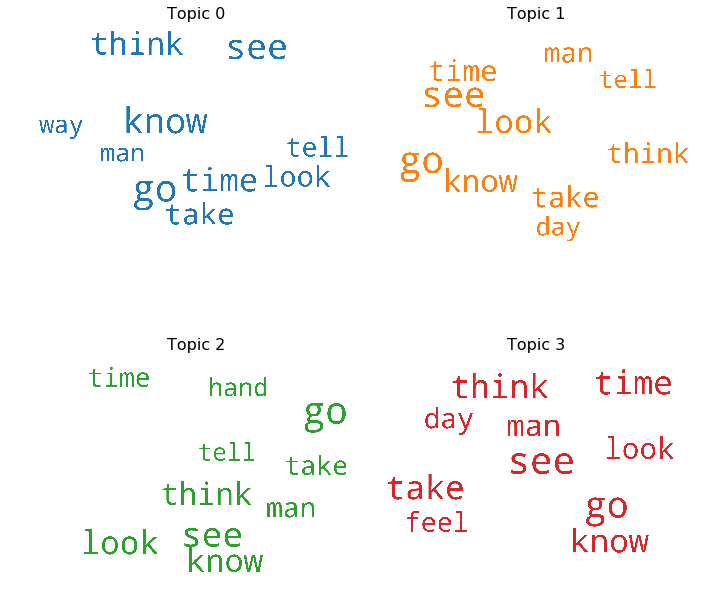

In [13]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Dominant topic and its percentage contribution in each document

In [16]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=textList):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(30)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.2158,"go, think, know, see, look, man, take, day, tell, time","[agn, anne, bronte, chapter, parsonage, history, contain, instruction, treasure, quantity, kerne..."
1,1,0.0,0.3375,"go, know, see, time, think, take, look, tell, man, way","[adventure, wonderland, lewi, carroll, chapter, rabbit, hole, begin, sit, sister, bank, nothing,..."
2,2,8.0,0.5952,"go, know, think, see, look, take, time, man, feel, day","[house, allington, anthony, trollope, chapter, squire, allington, course, house, allington, hous..."
3,3,7.0,0.2386,"go, know, see, look, think, take, man, tell, time, day","[london, hesba, stretton, chapter, sultry, day, dog, day, country, dusky, leaf, stir, stem, sunr..."
4,4,7.0,0.1522,"go, know, see, look, think, take, man, tell, time, day","[note, circulation, charles_dicken, emigrant, dedicate, book, friend, mine, america, welcome, re..."
5,5,0.0,0.4383,"go, know, see, time, think, take, look, tell, man, way","[story, amulet, nesbit, wallis, budge, british_museum, gratitude, unfail, kindness, help, chapte..."
6,6,6.0,0.2598,"go, see, man, look, think, know, day, take, hand, time","[fall, rome, wilkie, collin, chapter, goisvintha, mountain, form, range, alp, border, north, con..."
7,7,3.0,0.2020,"see, go, time, take, think, know, man, look, day, feel","[armadale, wilkie, collin, chapter, traveler, open, season, eighteen_hundr, bath, evening, shado..."
8,8,2.0,0.2330,"go, see, look, know, think, man, take, time, hand, tell","[awakening, select, story, kate, chapter, hang, cage, door, keep, repeat, allez, vous_en, allez,..."
9,9,1.0,0.1880,"go, see, look, know, time, take, man, think, day, tell","[hound, baskerville, arthur, conan, doyle, chapter, sherlock_holm, sherlock_holm, morning, save,..."


## pyLDAVIS: Visualise the information contained in a topic

In [116]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
28    -0.061196  0.041661       1        1  26.367647
13    -0.131655 -0.006227       2        1   7.308369
19    -0.152111 -0.102737       3        1   7.019538
38    -0.150635 -0.036270       4        1   6.484522
6     -0.177647  0.041164       5        1   6.430925
25    -0.159081 -0.047993       6        1   5.999199
32    -0.198822 -0.059683       7        1   5.233577
35    -0.126244 -0.048253       8        1   4.242401
30    -0.159523  0.106659       9        1   3.986646
15    -0.121368 -0.052901      10        1   3.091515
22    -0.129362 -0.065558      11        1   2.449837
14    -0.143899  0.067607      12        1   2.226679
10    -0.149443  0.148519      13        1   2.092111
2     -0.163171  0.107730      14        1   2.039465
36    -0.079732  0.141797      15        1   1.814845
33    -0.147800 -0.127458      16        1   1.767304
39    -0.138035 -0.105054      17        1   1.742511
9     -0.114211  0.051509      18        1   1.600695
16    -0.108924 -0.010450      19        1   1.262499
21    -0.158730  0.113575      20        1   1.146685
3     -0.144901  0.064772      21        1   1.078073
23    -0.088126 -0.067390      22        1   0.927387
1     -0.159791  0.076385      23        1   0.878444
27    -0.079760  0.037212      24        1   0.772559
34    -0.060151  0.004604      25        1   0.639204
37    -0.011536 -0.159232      26        1   0.451502
26    -0.095301 -0.006246      27        1   0.355334
11    -0.108105 -0.136093      28        1   0.337499
12     0.110947 -0.014806      29        1   0.166533
29     0.187137 -0.022657      30        1   0.084504
18     0.279697 -0.011029      31        1   0.001082
4      0.303144 -0.002150      32        1   0.000175
31     0.319402  0.008571      33        1   0.000091
8      0.337354  0.012633      34        1   0.000091
7      0.329016  0.010400      35        1   0.000091
17     0.336374  0.009624      36        1   0.000091
5      0.333539  0.007966      37        1   0.000091
24     0.323264  0.008065      38        1   0.000091
20     0.330432  0.009054      39        1   0.000091
0      0.328954  0.012679      40        1   0.000091, topic_info=      Category          Freq      Term         Total  loglift  logprob
1402   Default  43593.000000        go  43593.000000  30.0000  30.0000
3193   Default  30031.000000     think  30031.000000  29.0000  29.0000
1783   Default  34438.000000      know  34438.000000  28.0000  28.0000
1903   Default  26458.000000       man  26458.000000  27.0000  27.0000
2793   Default  36545.000000       see  36545.000000  26.0000  26.0000
1870   Default  28506.000000      look  28506.000000  25.0000  25.0000
373    Default   8525.000000       boy   8525.000000  24.0000  24.0000
3162   Default  18193.000000      tell  18193.000000  23.0000  23.0000
3222   Default  24814.000000      time  24814.000000  22.0000  22.0000
3145   Default  25774.000000      take  25774.000000  21.0000  21.0000
786    Default  19526.000000       day  19526.000000  20.0000  20.0000
2030   Default   8802.000000        mr   8802.000000  19.0000  19.0000
1226   Default  10062.000000    father  10062.000000  18.0000  18.0000
1790   Default   9788.000000      lady   9788.000000  17.0000  17.0000
3422   Default  10548.000000      want  10548.000000  16.0000  16.0000
1237   Default  13752.000000      feel  13752.000000  15.0000  15.0000
2031   Default   8680.000000       mrs   8680.000000  14.0000  14.0000
1573   Default  13493.000000     house  13493.000000  13.0000  13.0000
2019   Default   9605.000000    mother   9605.000000  12.0000  12.0000
2798   Default  12673.000000      seem  12673.000000  11.0000  11.0000
193    Default  11537.000000       ask  11537.000000  10.0000  10.0000
2301   Default  11911.000000     place  11911.000000   9.0000   9.0000
1475   Default  16831.000000      hand  16831.000000   8